# Keras - LSTM

bla

#### Importere biblioteker

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Making plots look better (Jupyter Notebook spesific)
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True

# Built in jupyter notebook commands
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Importere datasett

In [2]:
data_raw = pd.read_csv('data_ytrevikna_simple.csv',sep =';', low_memory = False)

data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237 entries, 0 to 5236
Data columns (total 16 columns):
YVIK-YtreVikna1-Sum-produksjon       5222 non-null float64
DNMI_75410...........T0015A3-0120    5237 non-null float64
/arome_windvel_6481_1056             5190 non-null float64
DNMI_75220...........T0015A3-0120    5237 non-null float64
/arome_windvel_6482_1114             5190 non-null float64
DNMI_75550...........T0015A3-0120    5237 non-null float64
/arome_windvel_6520_1098             5190 non-null float64
STORM-YVik1-Vindhast-25km            5237 non-null float64
STORM-YVik1-Vindretn-25km            5237 non-null int64
/arome_windvel_6495_1081             5190 non-null float64
/arome_windvel_6495_1096             5190 non-null float64
/arome_airtemp_6491_1087             5190 non-null float64
/arome_windvel_6491_1087             5190 non-null float64
/arome_windvel_6486_1082             5190 non-null float64
/arome_windvel_6486_1093             5190 non-null float64
Target    

In [3]:
data = data_raw.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5165 entries, 0 to 5236
Data columns (total 16 columns):
YVIK-YtreVikna1-Sum-produksjon       5165 non-null float64
DNMI_75410...........T0015A3-0120    5165 non-null float64
/arome_windvel_6481_1056             5165 non-null float64
DNMI_75220...........T0015A3-0120    5165 non-null float64
/arome_windvel_6482_1114             5165 non-null float64
DNMI_75550...........T0015A3-0120    5165 non-null float64
/arome_windvel_6520_1098             5165 non-null float64
STORM-YVik1-Vindhast-25km            5165 non-null float64
STORM-YVik1-Vindretn-25km            5165 non-null int64
/arome_windvel_6495_1081             5165 non-null float64
/arome_windvel_6495_1096             5165 non-null float64
/arome_airtemp_6491_1087             5165 non-null float64
/arome_windvel_6491_1087             5165 non-null float64
/arome_windvel_6486_1082             5165 non-null float64
/arome_windvel_6486_1093             5165 non-null float64
Target    

In [4]:
num_features = len(data.columns) -1
print(num_features)

15


#### Konvertere til numpy-arrays

In [5]:
# Konverterer pandas.DataFrame til en numpy array
all_features_and_target_value = data.values.astype("float32")

# Trekker ut alle features (5 aromepunkter med 4 features + delayed = 21 features)
x = all_features_and_target_value[:,0:num_features]

# Trekker ut produksjonen som y-verdi
y = all_features_and_target_value[:,num_features]

#### Train/test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 67, shuffle=False)

#### Skalere data

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Lage en scaler
scaler = MinMaxScaler()

# Anvende på features, her lagret i variablen x.
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.transform(X_test)

### Konvertere til tidserie matrise

In [8]:
# Definere variabler:
n_backward = 4

In [9]:
# Function for making time series
def make_time_series(row_features, look_back_num):
    list_of_matrices = []
    
    num_time_steps = look_back_num + 1
    
    i = num_time_steps
    
    while i < len(row_features):
        list_of_matrices.append(row_features[(i-num_time_steps):i,:])
        
        i = i + 1
    
    return list_of_matrices

In [10]:
x_train_matrix = np.asarray(make_time_series(X_train, n_backward))
x_test_matrix = np.asarray(make_time_series(X_test, n_backward))

In [11]:
x_train_matrix.shape

(3610, 5, 15)

In [12]:
x_train_matrix[0].shape

(5, 15)

#### Fjerne 'n_backward' antall rader, for å få like store sett

In [13]:
y_train_matrix = np.delete(y_train, [x for x in range(n_backward+1)], 0)
y_test_matrix = np.delete(y_test, [x for x in range(n_backward+1)], 0)

In [14]:
y_train_matrix.shape

(3610,)

# Keras

In [15]:
import tensorflow as tf

#### Importere modellen

In [16]:
from tensorflow.contrib.keras import models

In [17]:
dnn_keras_model = models.Sequential()

#### Sette opp layers

In [18]:
from tensorflow.contrib.keras import layers

In [19]:
# Input layer
dnn_keras_model.add(layers.LSTM(units=32, return_sequences = True, input_shape=(x_train_matrix.shape[1],x_train_matrix.shape[2]) ))

In [20]:
'''Hidden Layers'''

dnn_keras_model.add(layers.LSTM(units=32,activation='relu'))

In [21]:
# Output Layer
dnn_keras_model.add(layers.Dense(1))

#### Kompilere modellen

In [22]:
from tensorflow.contrib.keras import losses,optimizers,metrics,activations

In [23]:
#Kompilere - Alternative lossfunctions: mean_squared_error
dnn_keras_model.compile(optimizer='adam', loss = 'mean_absolute_error')

#### Trene modellen

In [24]:
from tensorflow.contrib.keras import losses,optimizers,metrics,activations

#### Callbacks og checkpoints

In [25]:
from tensorflow.contrib.keras import callbacks

In [26]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=500)

checkpoint = callbacks.ModelCheckpoint('checkpoint_model_LSTM_simple.h5', monitor = 'val_loss', 
                                       verbose = 1, save_best_only= True, mode= 'min')

In [28]:
# Trene modellen
np.random.seed(7)
dnn_keras_model.fit(x_train_matrix,y_train_matrix, epochs = 10000, batch_size=100, verbose=2, 
                       validation_split=0.2,
                       callbacks=[checkpoint,early_stopping])


# validation_split=0.20
#validation_data=(X_test, y_test)

Train on 2888 samples, validate on 722 samples
Epoch 1/10000
Epoch 00000: val_loss improved from inf to 5.06771, saving model to checkpoint_model_LSTM_simple.h5
2s - loss: 6.3700 - val_loss: 5.0677
Epoch 2/10000
Epoch 00001: val_loss improved from 5.06771 to 4.66824, saving model to checkpoint_model_LSTM_simple.h5
0s - loss: 4.1965 - val_loss: 4.6682
Epoch 3/10000
Epoch 00002: val_loss improved from 4.66824 to 4.36052, saving model to checkpoint_model_LSTM_simple.h5
0s - loss: 3.9951 - val_loss: 4.3605
Epoch 4/10000
Epoch 00003: val_loss did not improve
0s - loss: 3.7875 - val_loss: 4.7708
Epoch 5/10000
Epoch 00004: val_loss did not improve
0s - loss: 3.6106 - val_loss: 4.7654
Epoch 6/10000
Epoch 00005: val_loss did not improve
0s - loss: 3.5653 - val_loss: 4.4357
Epoch 7/10000
Epoch 00006: val_loss did not improve
0s - loss: 3.5669 - val_loss: 4.8141
Epoch 8/10000
Epoch 00007: val_loss did not improve
0s - loss: 3.4479 - val_loss: 4.5554
Epoch 9/10000
Epoch 00008: val_loss did not imp

Epoch 00082: val_loss did not improve
0s - loss: 2.4364 - val_loss: 4.0654
Epoch 84/10000
Epoch 00083: val_loss did not improve
0s - loss: 2.4792 - val_loss: 3.9320
Epoch 85/10000
Epoch 00084: val_loss did not improve
0s - loss: 2.4821 - val_loss: 3.9900
Epoch 86/10000
Epoch 00085: val_loss did not improve
0s - loss: 2.4715 - val_loss: 3.9224
Epoch 87/10000
Epoch 00086: val_loss did not improve
0s - loss: 2.4627 - val_loss: 3.9026
Epoch 88/10000
Epoch 00087: val_loss did not improve
0s - loss: 2.4317 - val_loss: 3.9521
Epoch 89/10000
Epoch 00088: val_loss did not improve
0s - loss: 2.4595 - val_loss: 3.8016
Epoch 90/10000
Epoch 00089: val_loss did not improve
0s - loss: 2.4958 - val_loss: 3.8817
Epoch 91/10000
Epoch 00090: val_loss did not improve
0s - loss: 2.4976 - val_loss: 3.9407
Epoch 92/10000
Epoch 00091: val_loss did not improve
0s - loss: 2.4682 - val_loss: 3.8390
Epoch 93/10000
Epoch 00092: val_loss did not improve
0s - loss: 2.4739 - val_loss: 3.7377
Epoch 94/10000
Epoch 0009

Epoch 00171: val_loss did not improve
0s - loss: 2.3007 - val_loss: 4.2513
Epoch 173/10000
Epoch 00172: val_loss did not improve
0s - loss: 2.2598 - val_loss: 3.6952
Epoch 174/10000
Epoch 00173: val_loss did not improve
0s - loss: 2.1430 - val_loss: 3.9982
Epoch 175/10000
Epoch 00174: val_loss did not improve
0s - loss: 2.0915 - val_loss: 3.8347
Epoch 176/10000
Epoch 00175: val_loss did not improve
0s - loss: 2.1222 - val_loss: 3.8754
Epoch 177/10000
Epoch 00176: val_loss did not improve
0s - loss: 2.1043 - val_loss: 3.8021
Epoch 178/10000
Epoch 00177: val_loss did not improve
0s - loss: 2.1660 - val_loss: 3.7857
Epoch 179/10000
Epoch 00178: val_loss did not improve
0s - loss: 2.1013 - val_loss: 3.8546
Epoch 180/10000
Epoch 00179: val_loss did not improve
0s - loss: 2.1615 - val_loss: 3.8029
Epoch 181/10000
Epoch 00180: val_loss did not improve
0s - loss: 2.1238 - val_loss: 3.8156
Epoch 182/10000
Epoch 00181: val_loss did not improve
0s - loss: 2.0986 - val_loss: 3.8118
Epoch 183/10000

Epoch 00262: val_loss did not improve
0s - loss: 1.9437 - val_loss: 3.9074
Epoch 264/10000
Epoch 00263: val_loss did not improve
0s - loss: 1.8680 - val_loss: 3.8052
Epoch 265/10000
Epoch 00264: val_loss did not improve
0s - loss: 1.8224 - val_loss: 4.0801
Epoch 266/10000
Epoch 00265: val_loss did not improve
0s - loss: 1.9685 - val_loss: 3.9997
Epoch 267/10000
Epoch 00266: val_loss did not improve
0s - loss: 1.9020 - val_loss: 3.8916
Epoch 268/10000
Epoch 00267: val_loss did not improve
0s - loss: 1.8654 - val_loss: 4.0417
Epoch 269/10000
Epoch 00268: val_loss did not improve
0s - loss: 1.8432 - val_loss: 4.0195
Epoch 270/10000
Epoch 00269: val_loss did not improve
0s - loss: 1.8570 - val_loss: 3.9545
Epoch 271/10000
Epoch 00270: val_loss did not improve
0s - loss: 1.9156 - val_loss: 3.9846
Epoch 272/10000
Epoch 00271: val_loss did not improve
0s - loss: 1.9007 - val_loss: 3.8481
Epoch 273/10000
Epoch 00272: val_loss did not improve
0s - loss: 1.8870 - val_loss: 3.8337
Epoch 274/10000

Epoch 00352: val_loss did not improve
0s - loss: 1.7040 - val_loss: 3.7820
Epoch 354/10000
Epoch 00353: val_loss did not improve
0s - loss: 1.6975 - val_loss: 3.8502
Epoch 355/10000
Epoch 00354: val_loss did not improve
0s - loss: 1.7128 - val_loss: 3.8273
Epoch 356/10000
Epoch 00355: val_loss did not improve
0s - loss: 1.7254 - val_loss: 3.8077
Epoch 357/10000
Epoch 00356: val_loss did not improve
0s - loss: 1.6571 - val_loss: 4.0491
Epoch 358/10000
Epoch 00357: val_loss did not improve
0s - loss: 1.6986 - val_loss: 3.9709
Epoch 359/10000
Epoch 00358: val_loss did not improve
0s - loss: 1.6871 - val_loss: 3.9169
Epoch 360/10000
Epoch 00359: val_loss did not improve
0s - loss: 1.6985 - val_loss: 3.8249
Epoch 361/10000
Epoch 00360: val_loss did not improve
0s - loss: 1.7471 - val_loss: 3.8265
Epoch 362/10000
Epoch 00361: val_loss did not improve
0s - loss: 1.7915 - val_loss: 4.0316
Epoch 363/10000
Epoch 00362: val_loss did not improve
0s - loss: 1.7240 - val_loss: 3.8084
Epoch 364/10000

Epoch 00443: val_loss did not improve
0s - loss: 1.6368 - val_loss: 3.9608
Epoch 445/10000
Epoch 00444: val_loss did not improve
0s - loss: 1.5538 - val_loss: 3.7750
Epoch 446/10000
Epoch 00445: val_loss did not improve
0s - loss: 1.6171 - val_loss: 3.8558
Epoch 447/10000
Epoch 00446: val_loss did not improve
0s - loss: 1.6264 - val_loss: 3.9356
Epoch 448/10000
Epoch 00447: val_loss did not improve
0s - loss: 1.5768 - val_loss: 3.8893
Epoch 449/10000
Epoch 00448: val_loss did not improve
0s - loss: 1.6332 - val_loss: 3.9556
Epoch 450/10000
Epoch 00449: val_loss did not improve
0s - loss: 1.6542 - val_loss: 3.9987
Epoch 451/10000
Epoch 00450: val_loss did not improve
0s - loss: 1.5702 - val_loss: 3.9856
Epoch 452/10000
Epoch 00451: val_loss did not improve
0s - loss: 1.5788 - val_loss: 3.7806
Epoch 453/10000
Epoch 00452: val_loss did not improve
0s - loss: 1.5285 - val_loss: 3.9447
Epoch 454/10000
Epoch 00453: val_loss did not improve
0s - loss: 1.5677 - val_loss: 3.7339
Epoch 455/10000

Epoch 00534: val_loss did not improve
0s - loss: 1.5849 - val_loss: 3.8458
Epoch 536/10000
Epoch 00535: val_loss did not improve
0s - loss: 1.5024 - val_loss: 3.7898
Epoch 537/10000
Epoch 00536: val_loss did not improve
0s - loss: 1.4427 - val_loss: 3.8661
Epoch 538/10000
Epoch 00537: val_loss did not improve
0s - loss: 1.4796 - val_loss: 4.0756
Epoch 539/10000
Epoch 00538: val_loss did not improve
0s - loss: 1.5025 - val_loss: 3.7509
Epoch 540/10000
Epoch 00539: val_loss did not improve
0s - loss: 1.6024 - val_loss: 3.9951
Epoch 541/10000
Epoch 00540: val_loss did not improve
0s - loss: 1.5247 - val_loss: 3.7192
Epoch 542/10000
Epoch 00541: val_loss did not improve
0s - loss: 1.5031 - val_loss: 3.8458
Epoch 543/10000
Epoch 00542: val_loss did not improve
0s - loss: 1.4675 - val_loss: 3.8064
Epoch 544/10000
Epoch 00543: val_loss did not improve
0s - loss: 1.4581 - val_loss: 3.8370
Epoch 545/10000
Epoch 00544: val_loss did not improve
0s - loss: 1.4680 - val_loss: 3.7916
Epoch 546/10000

Epoch 00623: val_loss did not improve
0s - loss: 1.4998 - val_loss: 3.7604
Epoch 625/10000
Epoch 00624: val_loss did not improve
0s - loss: 1.4707 - val_loss: 3.6904
Epoch 626/10000
Epoch 00625: val_loss did not improve
0s - loss: 1.4810 - val_loss: 3.6544
Epoch 627/10000
Epoch 00626: val_loss did not improve
0s - loss: 1.3943 - val_loss: 3.8484
Epoch 628/10000
Epoch 00627: val_loss did not improve
0s - loss: 1.4131 - val_loss: 3.7467
Epoch 629/10000
Epoch 00628: val_loss did not improve
0s - loss: 1.4130 - val_loss: 3.7313
Epoch 630/10000
Epoch 00629: val_loss did not improve
0s - loss: 1.3843 - val_loss: 3.8303
Epoch 631/10000
Epoch 00630: val_loss did not improve
0s - loss: 1.5670 - val_loss: 3.7389
Epoch 632/10000
Epoch 00631: val_loss did not improve
0s - loss: 1.5466 - val_loss: 3.8585
Epoch 633/10000
Epoch 00632: val_loss did not improve
0s - loss: 1.4130 - val_loss: 3.7962
Epoch 634/10000
Epoch 00633: val_loss did not improve
0s - loss: 1.4081 - val_loss: 3.8585
Epoch 635/10000

Epoch 00711: val_loss did not improve
0s - loss: 1.4217 - val_loss: 3.7884
Epoch 713/10000
Epoch 00712: val_loss did not improve
0s - loss: 1.4503 - val_loss: 3.7870
Epoch 714/10000
Epoch 00713: val_loss did not improve
0s - loss: 1.3878 - val_loss: 3.7119
Epoch 715/10000
Epoch 00714: val_loss did not improve
0s - loss: 1.3680 - val_loss: 3.6575
Epoch 716/10000
Epoch 00715: val_loss did not improve
0s - loss: 1.4148 - val_loss: 3.7136
Epoch 717/10000
Epoch 00716: val_loss did not improve
0s - loss: 1.3765 - val_loss: 3.7229
Epoch 718/10000
Epoch 00717: val_loss did not improve
0s - loss: 1.3751 - val_loss: 3.8056
Epoch 719/10000
Epoch 00718: val_loss did not improve
0s - loss: 1.3336 - val_loss: 3.7590
Epoch 720/10000
Epoch 00719: val_loss did not improve
0s - loss: 1.3837 - val_loss: 3.8970
Epoch 721/10000
Epoch 00720: val_loss did not improve
0s - loss: 1.3491 - val_loss: 3.6983
Epoch 722/10000
Epoch 00721: val_loss did not improve
0s - loss: 1.3340 - val_loss: 3.8486
Epoch 723/10000

Epoch 00802: val_loss did not improve
0s - loss: 1.4175 - val_loss: 3.8997
Epoch 804/10000
Epoch 00803: val_loss did not improve
0s - loss: 1.3458 - val_loss: 3.8844
Epoch 805/10000
Epoch 00804: val_loss did not improve
0s - loss: 1.3329 - val_loss: 3.6454
Epoch 806/10000
Epoch 00805: val_loss did not improve
0s - loss: 1.2918 - val_loss: 3.8277
Epoch 807/10000
Epoch 00806: val_loss did not improve
0s - loss: 1.4381 - val_loss: 4.0835
Epoch 808/10000
Epoch 00807: val_loss did not improve
0s - loss: 1.6360 - val_loss: 3.9022
Epoch 809/10000
Epoch 00808: val_loss did not improve
0s - loss: 1.3617 - val_loss: 3.6255
Epoch 810/10000
Epoch 00809: val_loss did not improve
0s - loss: 1.2916 - val_loss: 3.8378
Epoch 811/10000
Epoch 00810: val_loss did not improve
0s - loss: 1.3493 - val_loss: 3.6771
Epoch 812/10000
Epoch 00811: val_loss did not improve
0s - loss: 1.4803 - val_loss: 3.7100
Epoch 813/10000
Epoch 00812: val_loss did not improve
0s - loss: 1.3245 - val_loss: 3.8591
Epoch 814/10000

Epoch 00893: val_loss did not improve
0s - loss: 1.3119 - val_loss: 3.6716
Epoch 895/10000
Epoch 00894: val_loss did not improve
0s - loss: 1.2904 - val_loss: 3.7731
Epoch 896/10000
Epoch 00895: val_loss did not improve
0s - loss: 1.2568 - val_loss: 3.8703
Epoch 897/10000
Epoch 00896: val_loss did not improve
0s - loss: 1.2296 - val_loss: 3.7122
Epoch 898/10000
Epoch 00897: val_loss did not improve
0s - loss: 1.2854 - val_loss: 3.7549
Epoch 899/10000
Epoch 00898: val_loss did not improve
0s - loss: 1.2600 - val_loss: 4.0071
Epoch 900/10000
Epoch 00899: val_loss did not improve
0s - loss: 1.2677 - val_loss: 3.6684
Epoch 901/10000
Epoch 00900: val_loss did not improve
0s - loss: 1.3039 - val_loss: 3.8051
Epoch 902/10000
Epoch 00901: val_loss did not improve
0s - loss: 1.4069 - val_loss: 3.8229
Epoch 903/10000
Epoch 00902: val_loss did not improve
0s - loss: 1.3881 - val_loss: 3.6953
Epoch 904/10000
Epoch 00903: val_loss did not improve
0s - loss: 1.2801 - val_loss: 3.8060
Epoch 905/10000

Epoch 00984: val_loss did not improve
0s - loss: 1.2653 - val_loss: 3.7892
Epoch 986/10000
Epoch 00985: val_loss did not improve
0s - loss: 1.2169 - val_loss: 3.8146
Epoch 987/10000
Epoch 00986: val_loss did not improve
0s - loss: 1.2839 - val_loss: 3.8705
Epoch 988/10000
Epoch 00987: val_loss did not improve
0s - loss: 1.2414 - val_loss: 3.7537
Epoch 989/10000
Epoch 00988: val_loss did not improve
0s - loss: 1.2082 - val_loss: 3.8044
Epoch 990/10000
Epoch 00989: val_loss did not improve
0s - loss: 1.2266 - val_loss: 3.7447
Epoch 991/10000
Epoch 00990: val_loss did not improve
0s - loss: 1.2984 - val_loss: 3.9423
Epoch 992/10000
Epoch 00991: val_loss did not improve
0s - loss: 1.2116 - val_loss: 3.7940
Epoch 993/10000
Epoch 00992: val_loss did not improve
0s - loss: 1.1646 - val_loss: 3.8315
Epoch 994/10000
Epoch 00993: val_loss did not improve
0s - loss: 1.1782 - val_loss: 3.9034
Epoch 995/10000
Epoch 00994: val_loss did not improve
0s - loss: 1.2323 - val_loss: 3.7967
Epoch 996/10000

Epoch 01074: val_loss did not improve
0s - loss: 1.1548 - val_loss: 3.9855
Epoch 1076/10000
Epoch 01075: val_loss did not improve
0s - loss: 1.1829 - val_loss: 4.0062
Epoch 1077/10000
Epoch 01076: val_loss did not improve
0s - loss: 1.1906 - val_loss: 3.9903
Epoch 1078/10000
Epoch 01077: val_loss did not improve
0s - loss: 1.1731 - val_loss: 3.8530
Epoch 1079/10000
Epoch 01078: val_loss did not improve
0s - loss: 1.1653 - val_loss: 3.9244
Epoch 1080/10000
Epoch 01079: val_loss did not improve
0s - loss: 1.2757 - val_loss: 3.8195
Epoch 1081/10000
Epoch 01080: val_loss did not improve
0s - loss: 1.2453 - val_loss: 3.9329
Epoch 1082/10000
Epoch 01081: val_loss did not improve
0s - loss: 1.2728 - val_loss: 3.7545
Epoch 1083/10000
Epoch 01082: val_loss did not improve
0s - loss: 1.2049 - val_loss: 3.9392
Epoch 1084/10000
Epoch 01083: val_loss did not improve
0s - loss: 1.2006 - val_loss: 3.8451
Epoch 1085/10000
Epoch 01084: val_loss did not improve
0s - loss: 1.2636 - val_loss: 3.8109
Epoch

Epoch 01164: val_loss did not improve
0s - loss: 1.1760 - val_loss: 3.8593
Epoch 1166/10000
Epoch 01165: val_loss did not improve
0s - loss: 1.1458 - val_loss: 3.9397
Epoch 1167/10000
Epoch 01166: val_loss did not improve
0s - loss: 1.2730 - val_loss: 4.2728
Epoch 1168/10000
Epoch 01167: val_loss did not improve
0s - loss: 1.2121 - val_loss: 4.0351
Epoch 1169/10000
Epoch 01168: val_loss did not improve
0s - loss: 1.2204 - val_loss: 3.9335
Epoch 1170/10000
Epoch 01169: val_loss did not improve
0s - loss: 1.1377 - val_loss: 3.9682
Epoch 1171/10000
Epoch 01170: val_loss did not improve
0s - loss: 1.1286 - val_loss: 4.0501
Epoch 1172/10000
Epoch 01171: val_loss did not improve
0s - loss: 1.1925 - val_loss: 3.8924
Epoch 1173/10000
Epoch 01172: val_loss did not improve
0s - loss: 1.1595 - val_loss: 3.9468
Epoch 1174/10000
Epoch 01173: val_loss did not improve
0s - loss: 1.0934 - val_loss: 4.0389
Epoch 1175/10000
Epoch 01174: val_loss did not improve
0s - loss: 1.0908 - val_loss: 3.9621
Epoch

# Resultater

In [29]:
from sklearn import metrics

In [30]:
#finished_model = dnn_keras_model

finished_model = models.load_model('checkpoint_model_LSTM_simple.h5')

#### Prediksjon på testsett

In [31]:
final_preds = finished_model.predict(x_test_matrix)

In [33]:
# 5000 epocs , b_size = 10, 24(24)[10](1)
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_test_matrix, final_preds))
print('Mean Squared Error: \t\t\t', metrics.mean_squared_error(y_test_matrix, final_preds))
print('Root Mean Squared Error: \t\t', np.sqrt(metrics.mean_squared_error(y_test_matrix, final_preds)))

Mean Absolute Error: 			 4.72715
Mean Squared Error: 			 39.4888
Root Mean Squared Error: 		 6.28401


#### Prediksjon på treningdata

In [34]:
train_preds = finished_model.predict(x_train_matrix)

In [35]:
# 70% av data (benyttet til treningen)
print('Mean Absolute Error: \t\t\t', metrics.mean_absolute_error(y_train_matrix,train_preds))
print('Mean Squared Error: \t\t\t', metrics.mean_squared_error(y_train_matrix, train_preds))
print('Root Mean Squared Error: \t\t', np.sqrt(metrics.mean_squared_error(y_train_matrix, train_preds)))

Mean Absolute Error: 			 1.71308
Mean Squared Error: 			 8.7445
Root Mean Squared Error: 		 2.95711


# Visualisere resultater

#### Lager oversikt over testdataen

In [36]:
predictions = list(final_preds)

predictions_list = []

for pred in predictions:
    predictions_list.append(pred[0])

In [38]:
Oversikt = pd.DataFrame(data = {'real': y_test_matrix, 'predicitions': predictions_list})

Oversikt['differanse'] = Oversikt['real'] - Oversikt['predicitions'] 

Oversikt['abs_diff'] = Oversikt['differanse'].apply(abs)

### Scatterplot med fargekodede prediskjoner

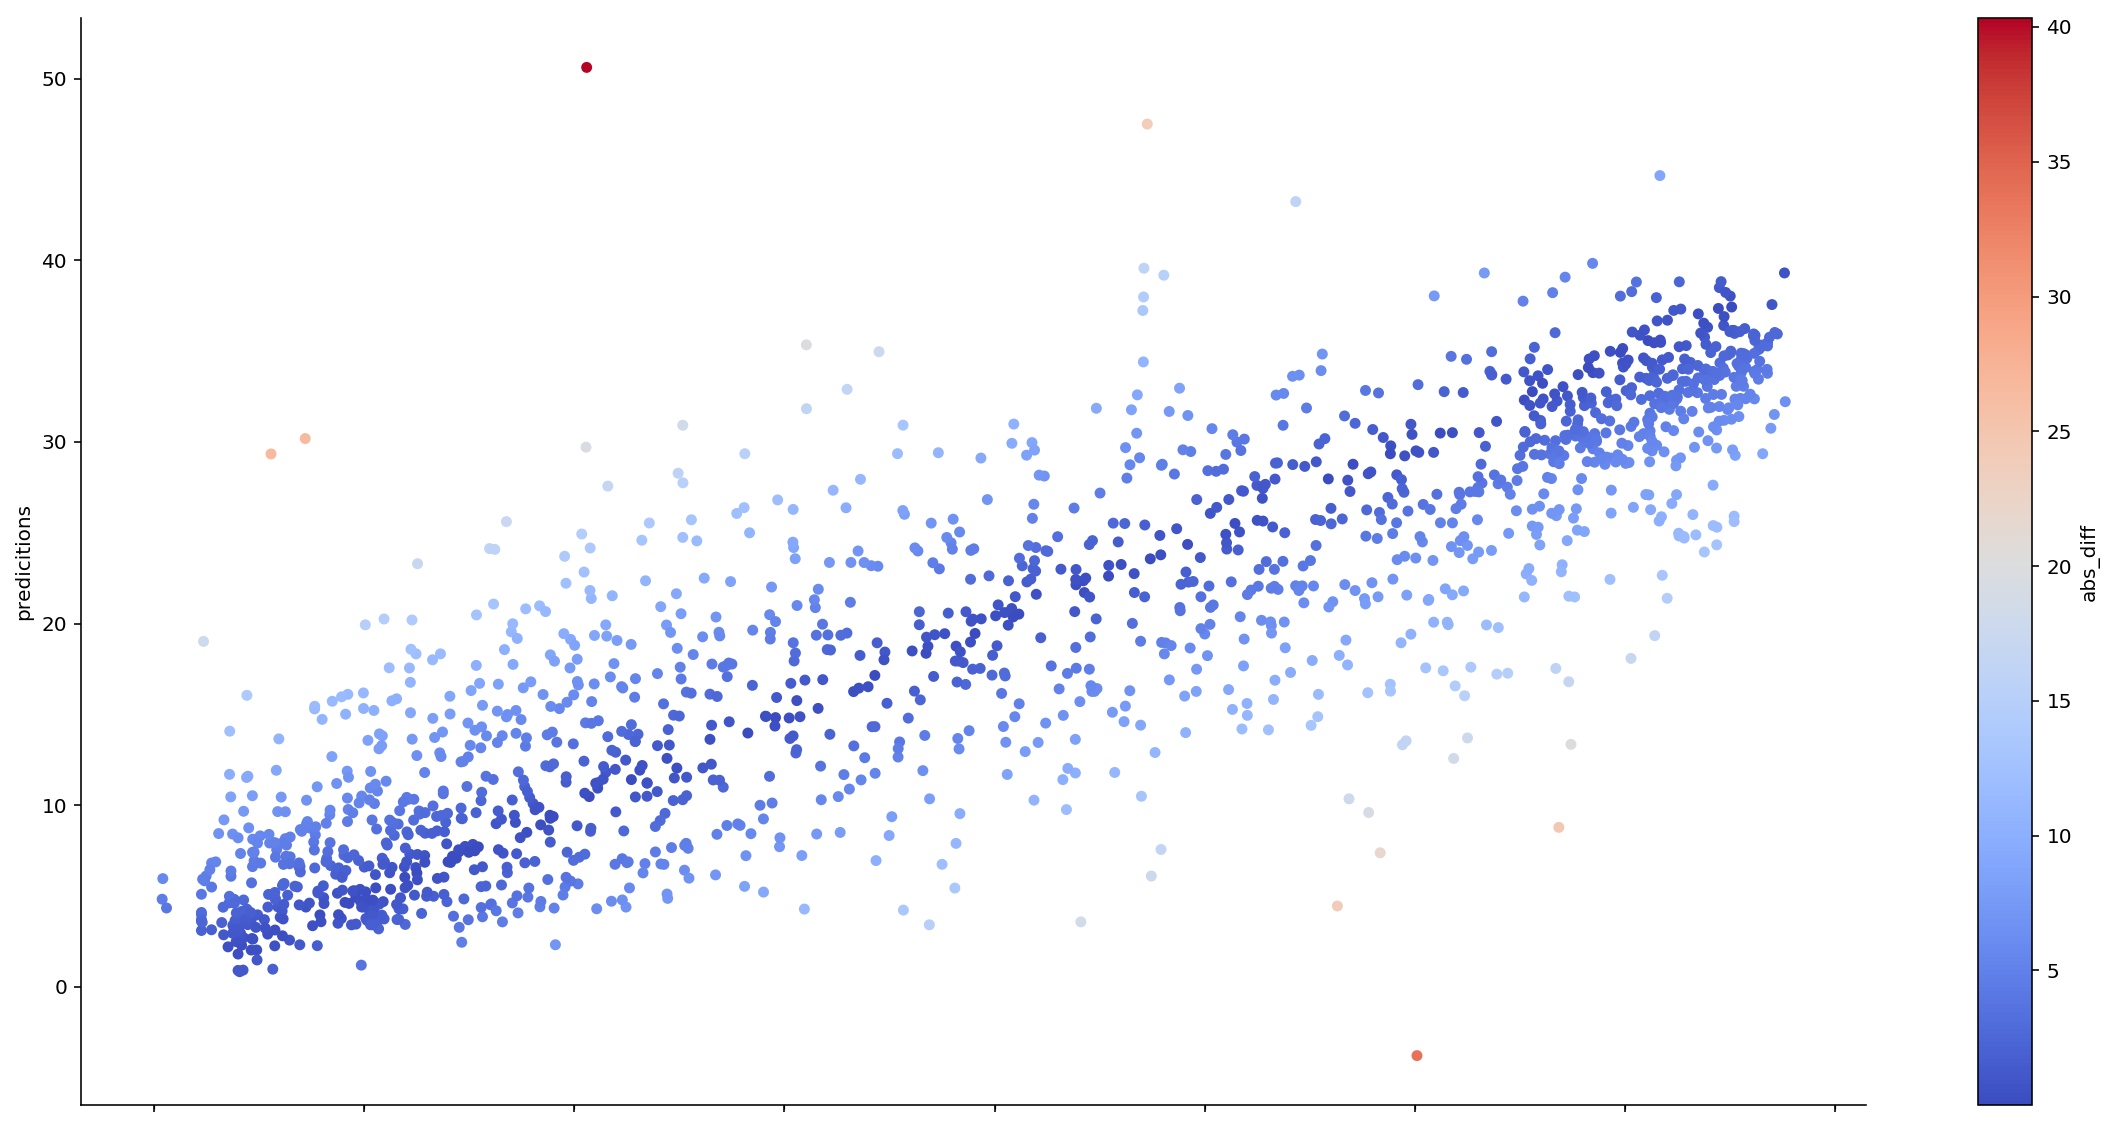

In [39]:
ax = Oversikt.plot.scatter(x='real',y='predicitions',
                   c='abs_diff',cmap='coolwarm', figsize = (20,10))

ax.set_xlabel("x label")

#remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig = ax.get_figure()
#fig.savefig('keras_model.png')

### Feilfordelingen av prediksjoner

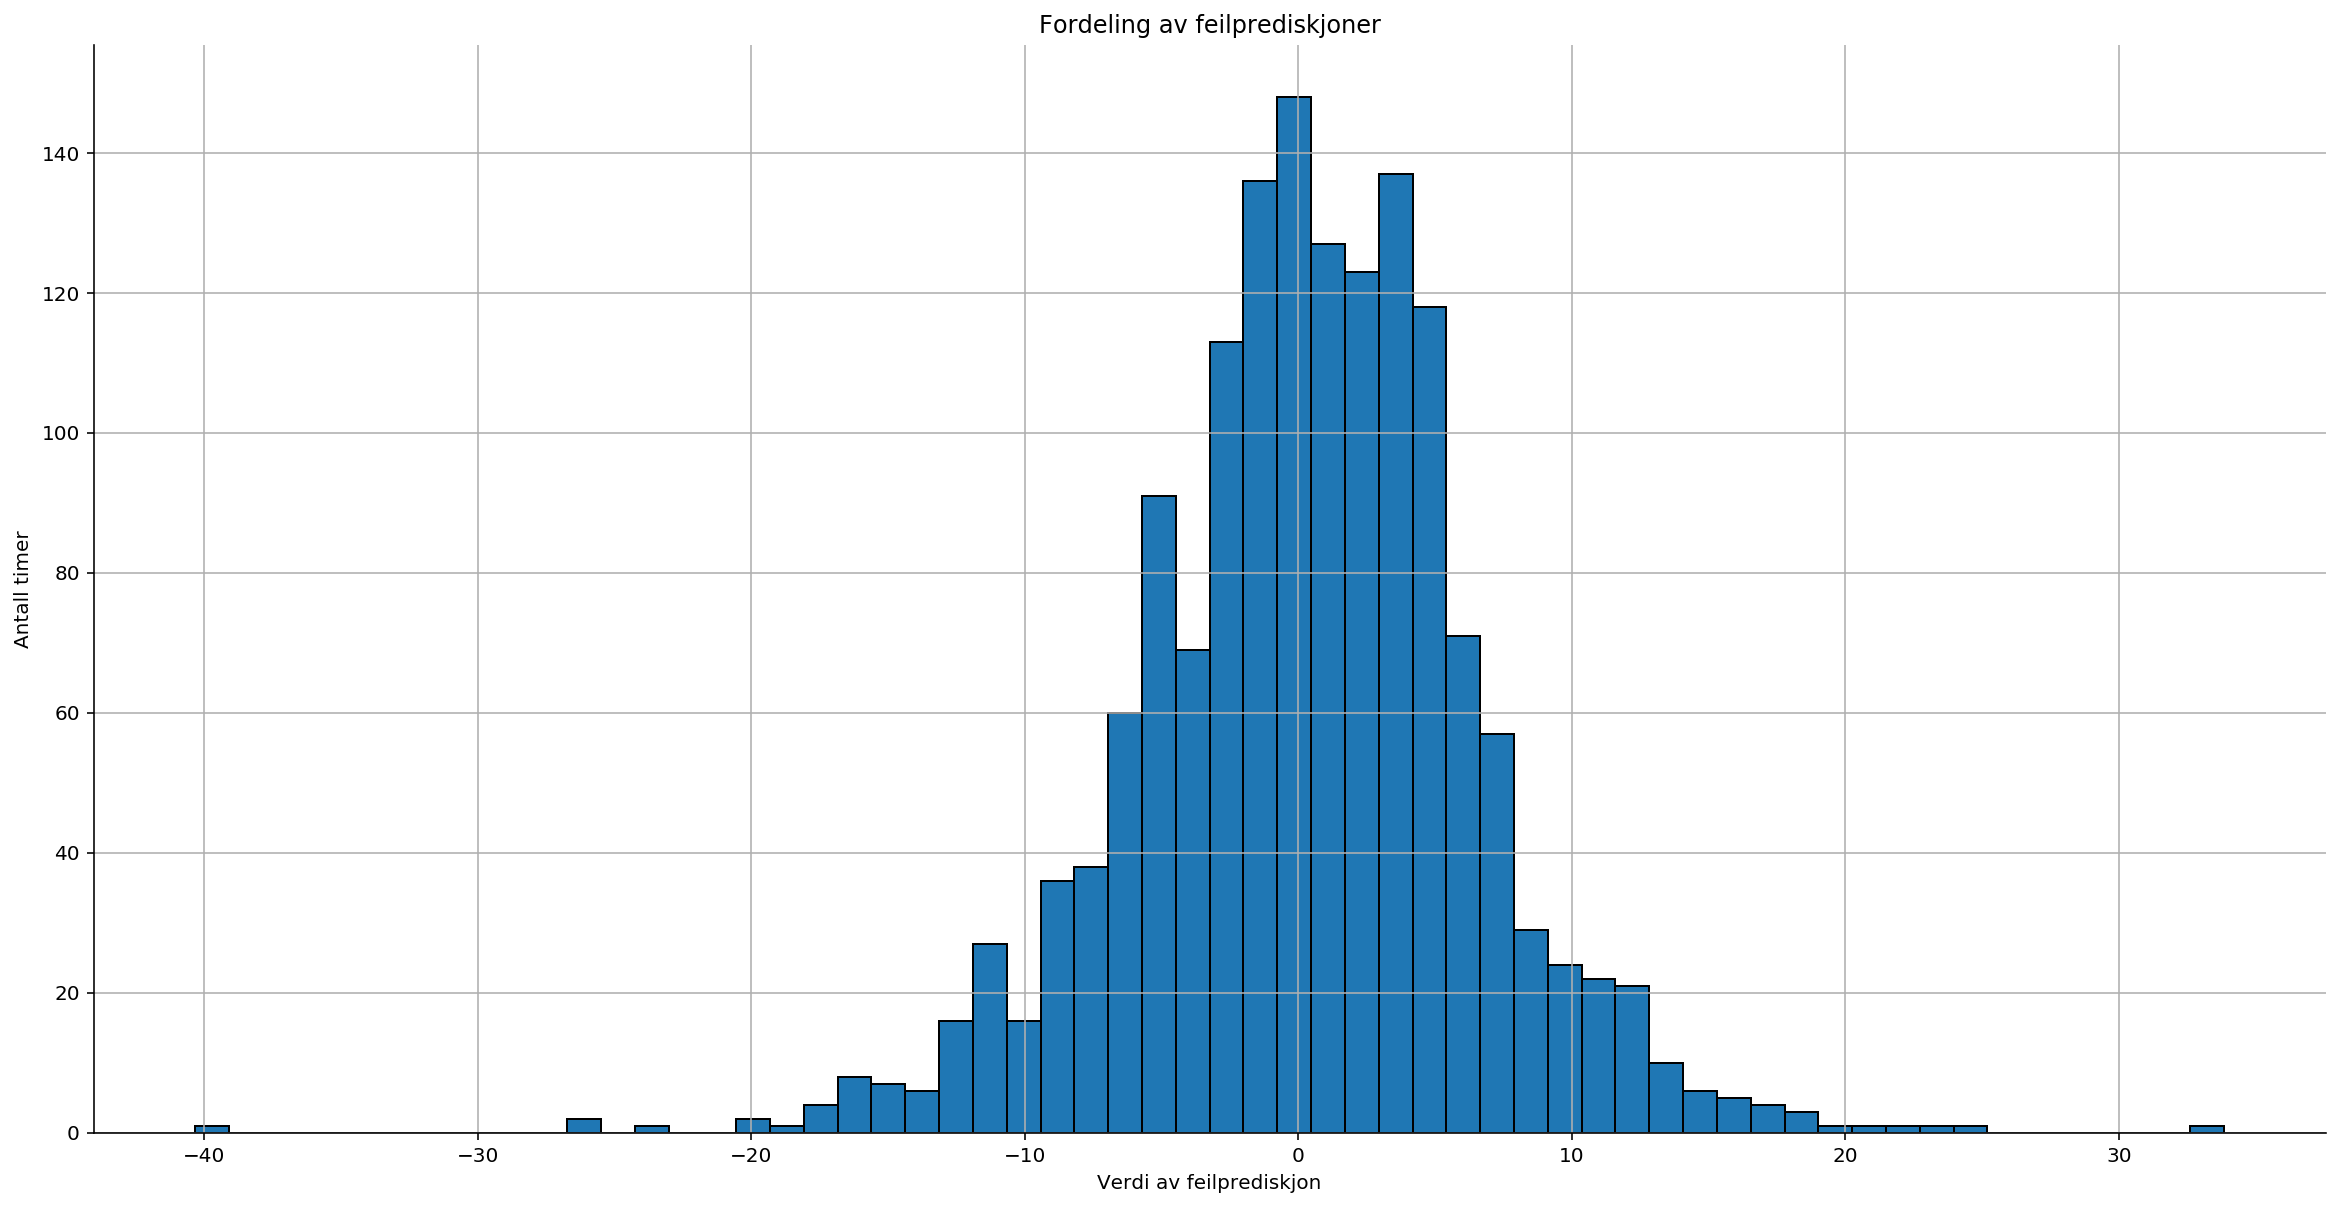

In [40]:
ax = Oversikt['differanse'].hist(bins=60,figsize = (20,10))

plt.xlabel('Verdi av feilprediskjon')
plt.ylabel('Antall timer')
plt.title('Fordeling av feilprediskjoner')

#remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig = ax.get_figure()
#fig.savefig('hist av abs.png')

# Ekte plott av prediksjonene

#### Forsøk på å hente ut et utdrag av dataen

In [41]:
all_predictions = finished_model.predict(x[:,:])

predictions_all = list(all_predictions)

predictions_all_list = []

for pred in predictions_all:
    predictions_all_list.append(pred[0])
    
timeline = pd.DataFrame(data = {'real': y[:], 'predicitions': predictions_all_list})

# Adjust in order to plot 'dagens modell'
data_raw.dropna(inplace=True)
data_raw.reset_index(inplace=True)

ValueError: Error when checking : expected lstm_1_input to have 3 dimensions, but got array with shape (5165, 15)

#### Tidsplot av data

In [ ]:
# Justere tidslinjen på plottet
start = 0
slutt = 20

ax = timeline.loc[start:slutt,'real'].plot(figsize=(20,8))
ax = timeline.loc[start:slutt,'predicitions'].plot(figsize=(20,8))
ax = data_raw.loc[start:slutt,'YVIK-YtreVikna1-Sum-produksjon'].plot(figsize=(20,8))

 
plt.xlabel('Tid (antall timer)')
plt.ylabel('Produksjon i Mega Watt (MW)')
plt.title('Utdrag fra tidsperioden')

plt.legend(loc='best')

#remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Saves figure
fig = ax.get_figure()
#fig.savefig('september10.png')